In [1]:
from astropy.io import fits
import os
import numpy as np
import matplotlib.pyplot as plt


pth = 'D:\\fits\\20160815\\sp_20160815_061839\\hao\\web\\csac.hao.ucar.edu\\data\\hinode\\sot\\level1\\2016\\08\\15\\SP3D\\20160815_061839\\SP3D20160815_065803.6C.fits'
file = fits.open(pth)

Просматривая данные, можно увидеть, что зашумленность спектров бывает разной:

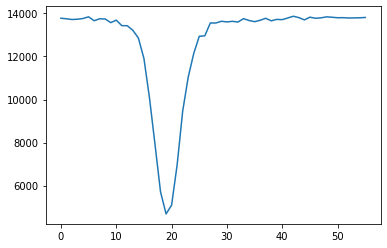

In [10]:
plt.plot(file[0].data[0][0][56:])

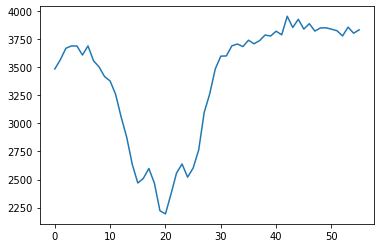

In [9]:
plt.plot(file[0].data[0][329][56:])

Для компонент Q, U, V это проявляется еще сильнее:

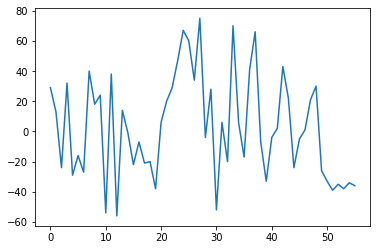

In [18]:
plt.plot(file[0].data[3][0][56:])

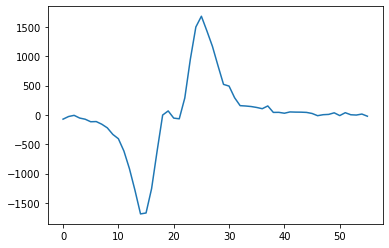

In [17]:
plt.plot(file[0].data[3][329][56:])

# Для правильного моделирования нужно разобраться, как формируются эти шумы.



В реальности помимо полезного сигнала приемник (камера в данном случае) всегда собирает еще какое-то количество "мусорного" сигнала.
Можно предположить, что объем этого "мусора" всегда постоянен и не зависит от поступающего сигнала. Результирующий спектр будет суммой реального излучения Солнца и шума. Когда спектр снимается с пятна - излучения меньше и шум будет больше выделяться в результирующем спектре.

Физически ни одна из компонент I, Q, U, V не измеряется. В реальности измеряются пары (I + Q, I - Q), (I + U, I - U), (I + V, I - V). 

В таком случае I получается суммированием:

I = 0.5( (I + V) + (I - V))

Q, U, V вычитанием:

Q = 0.5( (I + Q) - (I - Q))

Из-за этого стоит ожидать, что уровень шума для разных компонент будет разным (Q и U близки по своему физическому смыслу, так что у них шум может и совпадать).



# Как оценить распределение шума?



Из модели известно, что параметры Q, U и V при удалении от центра линии должны стремиться к нулю. В таком случае, величину крайних пикселей в спектре будет определять именно шум. Можно собрать статистику для большого количества:

In [42]:
Q_noise = file[0].data[1, :, -1]
U_noise = file[0].data[2, :, -1]
V_noise = file[0].data[3, :, -1]

(array([  2.,   1.,   4.,  35.,  82., 119., 131.,  98.,  29.,  11.]),
 array([-152. , -126.3, -100.6,  -74.9,  -49.2,  -23.5,    2.2,   27.9,
          53.6,   79.3,  105. ]),
 <a list of 10 Patch objects>)

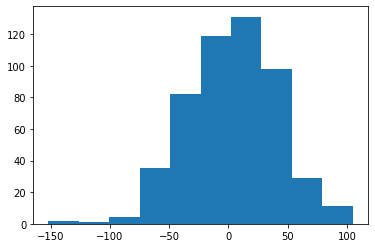

In [41]:
plt.hist(Q_noise)

In [ ]:
Видим, что распределение похоже на нормальное

Оценим дисперсию:

In [43]:
np.std(Q_noise)

37.134936868458055

In [44]:
np.std(U_noise)

35.221382753521596

In [45]:
np.std(V_noise)

32.240598032589645

# Как оценить шум для I?

В случае с I модельный профиль при удалении от линии стремится не к 0, а к интенсивности континуума. Просто брать крайние точки нельзя - в каждой помимо шумов прибавлен еще и разный сигнал. 

Однако мы можем взять разность двух ближайших точек - в них прибавка в виде континуума будет близкой:

In [49]:
I_noise = file[0].data[0, :, -1] - file[0].data[0, :, -2]

(array([  4.,   2.,  15.,  39., 153., 233.,  44.,  13.,   6.,   3.]),
 array([-516. , -414.6, -313.2, -211.8, -110.4,   -9. ,   92.4,  193.8,
         295.2,  396.6,  498. ]),
 <a list of 10 Patch objects>)

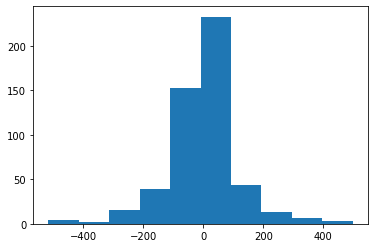

In [50]:
plt.hist(I_noise)

In [ ]:
Полученная величина является суммой двух нормально распределенных величин. В таком случае, интересующая нас дисперсия:

In [51]:
np.std(I_noise)/np.sqrt(2)

82.01387500839984

Можно уточнить оценку, чтобы уменьшить влияние разности уровня сигнала между двумя точками:

In [59]:
I_noise = (file[0].data[0, :, -1] - file[0].data[0, :, -2]) + (file[0].data[0, :, -3] - file[0].data[0, :, -2])

In [61]:
np.std(I_noise)/np.sqrt(6)

89.39190755412007